<a href="https://colab.research.google.com/github/YuxingW/machine_learning/blob/main/hw2_clustering/golden_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### What is the story

For power supply company and electronics manufacturers, they can be interested in finding the customers whose power consumptions stably increase every year. <br />
This note book is to find these customers as a golden cluster based on: <br />
Dataset<br />
&nbsp;  &nbsp; &nbsp; 114 apartments yearly power consumption in 2014-2016<br />

Objective fuctions<br />
  1. Average yearly incremental rate of power consumption is high<br />
  2. Variance among yearly incremental rate is low<br />

In [70]:
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from io import BytesIO

Load the dataset which has aggregated the power consumption data of 114 apartments to yearly basis.

In [71]:
train_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTSrkksG6J0eW2uQVdlLoYvcc52nL4jtLx2snJxAMzXDpliwgHjjpuLdKTyaWA3r89Xz2NExw0_hNK1/pub?output=csv'
r = requests.get(train_url)
data = r.content
stats = pd.read_csv(BytesIO(data))
stats.head()

,apt,sum_2014,sum_2015,sum_2016
0,1,2459.677764,3975.893503,4173.596942
1,2,3644.218922,5346.137168,5809.360482
2,3,1.216667,1966.595428,4882.375903
3,4,2516.462672,2912.109103,1823.633984
4,5,3917.460015,4776.046606,4204.387063


### Data preprosessing
Get 114 apartments overall yearly average power consumption

In [72]:
avg_2014 = stats['sum_2014'].to_numpy().sum()/114
avg_2015 = stats['sum_2015'].to_numpy().sum()/114
avg_2016 = stats['sum_2016'].to_numpy().sum()/114
print('avg_2014: %s avg_2015: %s avg_2016: %s' % (avg_2014, avg_2015, avg_2016))

avg_2014: 2595.3284100206315 avg_2015: 4638.032251017544 avg_2016: 4592.061797868421


Fill overall average power consumption data for apartments that do not have any sensor data in 2014

In [73]:
def set_avg(x):
  return x if x > 2 else avg_2014

stats['sum_2014'] = stats['sum_2014'].apply(set_avg)
stats.head()

,apt,sum_2014,sum_2015,sum_2016
0,1,2459.677764,3975.893503,4173.596942
1,2,3644.218922,5346.137168,5809.360482
2,3,2595.328410,1966.595428,4882.375903
3,4,2516.462672,2912.109103,1823.633984
4,5,3917.460015,4776.046606,4204.387063


### Created interested composite features
inc_2015: increment rate of power consuption from 2014 to 2015 <br />
inc_2016: increment rate of power consuption from 2015 to 2016 <br />
avg_years: average increment rate of power consuption from 2014 to 2016 <br />
var_years: variance of increment rates from 2014 to 2016

In [74]:
extra_feats = {
     'inc_2015': lambda x: np.true_divide(x['sum_2015']-x['sum_2014'], x['sum_2014']),
     'inc_2016': lambda x: np.true_divide(x['sum_2016']-x['sum_2015'], x['sum_2015']),
     'avg_years': lambda x: np.true_divide(x['inc_2015']+x['inc_2016'], 2),
     'var_years': lambda x: np.true_divide((x['inc_2015']-x['avg_years'])**2 \
                                        + (x['inc_2016']-x['avg_years'])**2, 2)
}
stats = stats.assign(**extra_feats)

stats.head()

,apt,sum_2014,sum_2015,sum_2016,inc_2015,inc_2016,avg_years,var_years
0,1,2459.677764,3975.893503,4173.596942,0.616429,0.049726,0.333077,0.080288
1,2,3644.218922,5346.137168,5809.360482,0.467019,0.086646,0.276833,0.036171
2,3,2595.328410,1966.595428,4882.375903,-0.242256,1.482654,0.620199,0.743828
3,4,2516.462672,2912.109103,1823.633984,0.157223,-0.373776,-0.108276,0.070490
4,5,3917.460015,4776.046606,4204.387063,0.219169,-0.119693,0.049738,0.028707


### Fractal clustering
Clustering apartments based on each of them average increment and variance over years. <br />

Plot SSE and silhouette score by KMean clustering with different clusters.

In [75]:
df_main = stats[['apt', 'avg_years', 'var_years']]
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   apt        114 non-null    int64  
 1   avg_years  114 non-null    float64
 2   var_years  114 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 2.8 KB


In [76]:
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn import metrics

In [15]:
def plot_cluster(df, max_loop=50):
    """
    Looking at the performance of various number of clusters using K-Means.
    Performance is evaluated by within cluster SSE and silhouette score.
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]
    
    # robust scaling is used so that the centering and scaling statistics are therefore not influenced by a few number of very large marginal outliers as they are based on percentiles
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    
    sse_within_cluster = {}
    silhouette_score = {}
    
    for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10, n_jobs=-1)
        kmeans.fit(X_rb)
        sse_within_cluster[k] = kmeans.inertia_
        silhouette_score[k] = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)

    _ = plt.figure(figsize=(10,6))
    ax1 = plt.subplot(211)
    _ = plt.plot(list(sse_within_cluster.keys()), list(sse_within_cluster.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("SSE Within Cluster")
    _ = plt.title("Within Cluster SSE After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    ax2 = plt.subplot(212)
    _ = plt.plot(list(silhouette_score.keys()), list(silhouette_score.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("Silhouette Score")
    _ = plt.title("Silhouette Score After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)

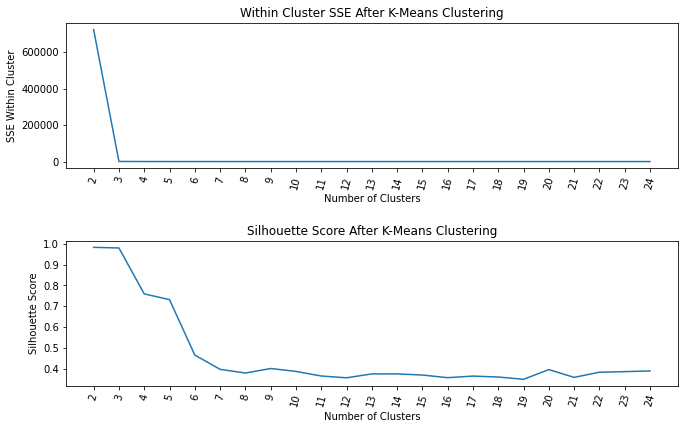

In [77]:
plot_cluster(df_main, max_loop=25)

Note the drop in sihouette score is quite significant between 5 clusters and 6 clusters, I would use 5 clusters in my K-Means model below.

In [17]:
def apply_cluster(df, clusters=2):
    """
    Applying K-Means with the optimal number of clusters identified
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    kmeans = KMeans(n_clusters=clusters, random_state=10, n_init=10, n_jobs=-1)  
    kmeans.fit(X_rb) 
    score = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)
    df['cluster'] = kmeans.labels_
    sse_within_cluster = kmeans.inertia_
    
    print("clustering performance")
    print("-----------------------------------")
    print("silhouette score: " + str(score.round(2)))
    print("sse withing cluster: " + str(sse_within_cluster.round()))
    
    return df


In [78]:
first_trial = apply_cluster(df_main, clusters=5)

clustering performance
-----------------------------------
silhouette score: 0.73
sse withing cluster: 116.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [21]:
cluster_perf_df = (
    first_trial
    .groupby('cluster')
    .agg({"avg_years":"mean", "var_years":"mean", "apt":"count"})
    .sort_values('avg_years')
    .reset_index()
)

cluster_perf_df

,cluster,avg_years,var_years,apt
0,0,0.321340,0.168014,99
1,3,1.197664,1.446857,12
2,4,2.503654,4.512110,1
3,2,16.270298,264.299082,1
4,1,28.457669,794.580368,1


Most of the apartments are aggregated in cluster 0. For the other clusters, we can see that the variance over years are huge.
As cluster 0 variance is low and it contains many apartments data, I will continue to conduct another K-Means clustering on cluster 0. So, the method I am adopting is fractal clustering.

In [79]:
df_main_sub = df_main.query("cluster == 0").reset_index(drop=True)
df_main_sub.head()

,apt,avg_years,var_years,cluster
0,1,0.333077,0.080288,0
1,2,0.276833,0.036171,0
2,3,0.620199,0.743828,0
3,4,-0.108276,0.070490,0
4,5,0.049738,0.028707,0


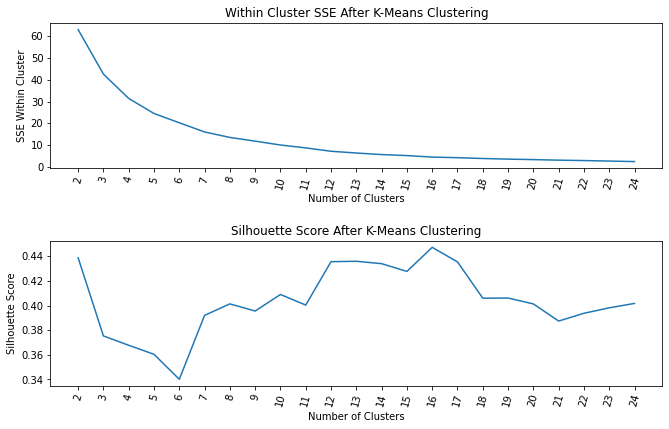

In [80]:
plot_cluster(df_main_sub, max_loop=25)


From the graph, Silhouette Score After K-Means Clustering, we can see that there were continuous drops between 3 clusters and 6 clusters, and continuous raises between 6 and 16. As such, I would use 16 clusters in my K-Means model below

In [81]:
second_trial= apply_cluster(df_main_sub, clusters=16)

clustering performance
-----------------------------------
silhouette score: 0.45
sse withing cluster: 4.0


In [82]:
sub_cluster_perf_df = (
    second_trial
    .groupby('cluster')
    .agg({"avg_years":"mean", "var_years":"mean", "apt":"count"})
    .sort_values('avg_years')
    .reset_index()
)

sub_cluster_perf_df

,cluster,avg_years,var_years,apt
0,13,-0.229160,0.236649,1
1,4,-0.222317,0.046124,5
2,1,0.100529,0.042221,15
3,9,0.164569,0.202790,6
4,14,0.249971,0.033211,12
5,6,0.298706,0.389630,4
6,10,0.336428,0.122033,11
7,12,0.393557,0.252659,8
8,5,0.395772,0.025628,8
9,0,0.472175,0.184565,9


Similar to the sharpe ratio in stock, we want to see a ratio between avg_years and var_years

In [83]:
extra_feats = {
     'ratio': lambda x: np.true_divide(x['avg_years'], x['var_years'])
}
sub_cluster_perf_df = sub_cluster_perf_df.assign(**extra_feats)
sub_cluster_perf_df

,cluster,avg_years,var_years,apt,ratio
0,13,-0.229160,0.236649,1,-0.968355
1,4,-0.222317,0.046124,5,-4.819966
2,1,0.100529,0.042221,15,2.381004
3,9,0.164569,0.202790,6,0.811524
4,14,0.249971,0.033211,12,7.526773
5,6,0.298706,0.389630,4,0.766642
6,10,0.336428,0.122033,11,2.756858
7,12,0.393557,0.252659,8,1.557658
8,5,0.395772,0.025628,8,15.443247
9,0,0.472175,0.184565,9,2.558306


In [84]:
golden_cluster = second_trial.query("cluster == 5")
golden_cluster


,apt,avg_years,var_years,cluster
7,8,0.450322,0.000539,5
12,16,0.458760,0.032598,5
29,35,0.336468,0.024315,5
33,39,0.392282,0.047111,5
40,47,0.430771,0.001588,5
55,66,0.394044,0.001866,5
61,72,0.355001,0.057790,5
90,104,0.348531,0.039213,5


Print the power consumption of the golden_cluster and we can see the results are reasonable

In [85]:
apts = golden_cluster['apt'].to_numpy()
golden_df = stats[stats.apt.isin(apts)]
golden_df

,apt,sum_2014,sum_2015,sum_2016,inc_2015,inc_2016,avg_years,var_years
7,8,3557.161673,5076.478927,7480.335970,0.427115,0.473528,0.450322,0.000539
15,16,2344.647626,3843.603452,4912.931646,0.639310,0.278210,0.458760,0.032598
34,35,1746.730537,2606.821325,3077.445859,0.492400,0.180536,0.336468,0.024315
38,39,3650.271381,5874.499687,6903.899063,0.609332,0.175232,0.392282,0.047111
46,47,1896.749811,2789.400456,3879.833077,0.470621,0.390920,0.430771,0.001588
65,66,2646.359887,3803.466287,5137.886077,0.437245,0.350843,0.394044,0.001866
71,72,2512.914941,4009.097852,4468.561013,0.595397,0.114605,0.355001,0.057790
103,104,2774.087567,3191.609382,4935.994652,0.150508,0.546553,0.348531,0.039213
